# 🎯 What Are Masks and Atlases in Neuroimaging?

### 🟢 **Mask**

* A **mask** is simply a **binary image** (NIfTI file) the same size as your brain image.
* It tells the computer **which voxels to include (1)** and **which voxels to ignore (0)**.
* Example:

  * A *whole-brain mask* includes only brain tissue, excludes skull/air.
  * An *ROI mask* selects one specific region, e.g., hippocampus.

👉 Think of it like a **cookie cutter**: it shapes what part of the brain image you want to keep.

---

### 🟢 **Atlas**

* An **atlas** is like a **map of the brain** where each region has a unique label (integer value).
* Instead of just 0/1, each voxel has a number (1, 2, 3 …).
* Each number corresponds to a brain region name (stored in a label file).
* Example:

  * AAL atlas: `1 = Precentral_L`, `2 = Precentral_R`, `3 = Frontal_Sup_L`, etc.

👉 Think of it like a **city map**: each neighborhood (ROI) has a different color/ID.

---

### 🧠 Why Do We Use Them?

1. **Extract regional signals** – average fMRI time series within a region.
2. **Focused analysis** – only study the brain part relevant to your question.
3. **Cross-subject consistency** – same atlas → compare the same region across people.

## **Basic Atlas Loading & Plotting**

### 1) Imports

In [2]:
from nilearn import datasets, plotting, image
import nibabel as nib
import numpy as np
import pandas as pd

### 2) Fetch the Harvard–Oxford cortical atlas (max-probability, 25% threshold, 2mm)

    - "maxprob" atlases are 3D label images (each voxel is an integer region ID).
    
    - You also get region names in .labels and a BIDS-style LUT (DataFrame) in .lut.

In [ ]:

HOA = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')  # returns a Bunch
atlas_path=HOA.filename       # path to the NIfTI atlas file (preferred key)
atlas_map = HOA.maps       
labels = list(HOA.labels)    # list of region names (index i matches integer label i)
lut = getattr(HOA, 'lut', None)  # pandas DataFrame with 'index' and 'name' (if available)

print(f"Atlas file: {atlas_path}")
labels[:10]

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl
Atlas file: C:\Users\Saye\nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division']

### 3)  Inspect atlas header & unique labels actually present in the volume.

In [7]:
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()
unique_ints = np.unique(atlas_data.astype(int))
present_region_ids = [i for i in unique_ints if i > 0]  # exclude 0 = background

print(f"Image shape: {atlas_img.shape} | affine:\n{atlas_img.affine}")
print(f"Number of distinct labels found (excluding 0): {len(present_region_ids)}")

Image shape: (91, 109, 91) | affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Number of distinct labels found (excluding 0): 48



### 4) Quick visualization
 1 — plot_anat on the atlas itself 

     NOTE: plot_anat is meant for anatomical T1 images; passing the atlas will

     just show the integer labels as intensities. It's OK for a quick peek, but

     not semantically ideal.

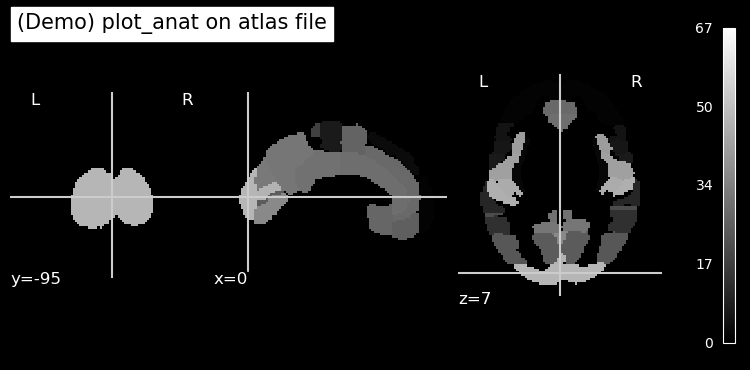

In [8]:
plotting.plot_anat(atlas_path, title="(Demo) plot_anat on atlas file")
plotting.show()

### 5) Quick visualization 

2 — plot ROI-style view of the atlas (recommended)

    plot_roi is designed for masks/atlases; it overlays on an MNI template by default.

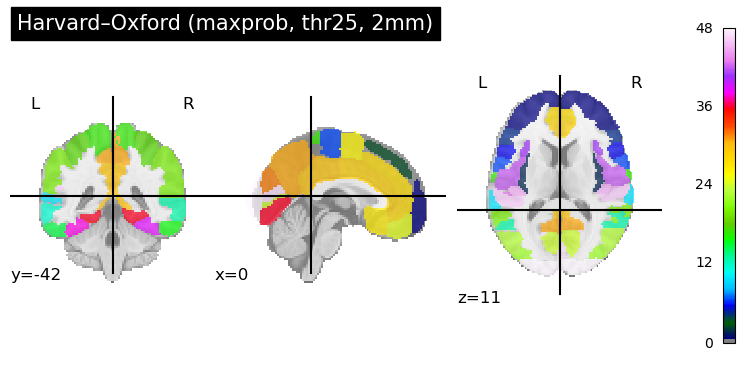

In [9]:

plotting.plot_roi(atlas_path, title="Harvard–Oxford (maxprob, thr25, 2mm)")
plotting.show()

### 6)  show atlas as contours 

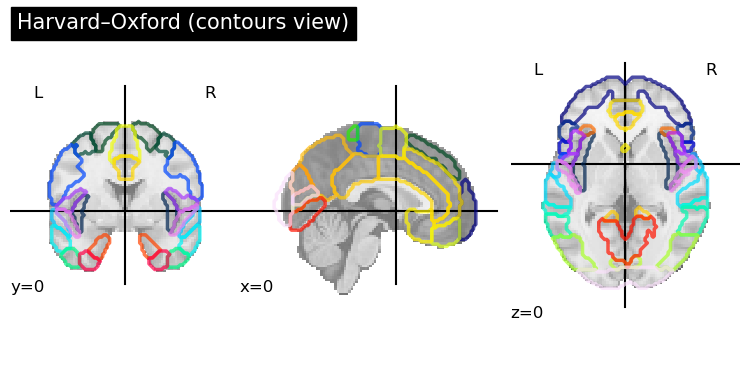

In [10]:
plotting.plot_roi(
    atlas_path,
    view_type="contours",
    title="Harvard–Oxford (contours view)"
)
plotting.show()

### 7) Pick ONE actual region ID present in the image and build a binary mask for it.

    This demonstrates "mask = binary image selecting an ROI".
    
    We pick the first non-zero ID found in the atlas volume.

Example region: id=1, name=Frontal Pole


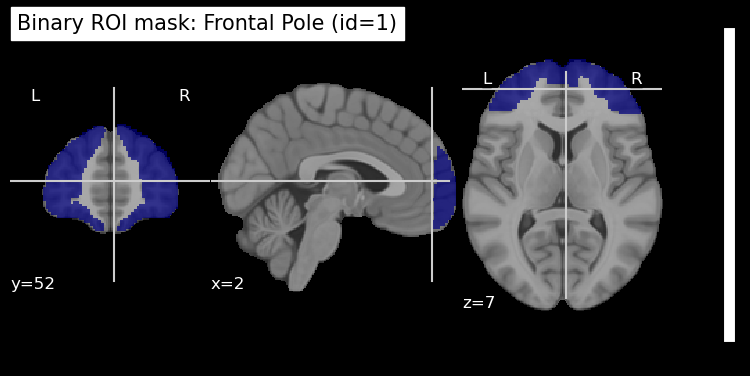

In [11]:
region_id = int(present_region_ids[0])
region_name = labels[region_id] if region_id < len(labels) else f"Region {region_id}"
print(f"Example region: id={region_id}, name={region_name}")

# Build a binary mask for that region (1 inside the region, 0 elsewhere)
region_mask_data = (atlas_data == region_id).astype(np.int16)
region_mask_img = nib.Nifti1Image(region_mask_data, atlas_img.affine, atlas_img.header)

# Visualize the binary ROI mask over an MNI T1 template explicitly
mni_bg = datasets.load_mni152_template()  # background anatomical image
plotting.plot_roi(
    region_mask_img,
    bg_img=mni_bg,
    title=f"Binary ROI mask: {region_name} (id={region_id})"
)
plotting.show()

### 8) (If you have the LUT) show the first few rows to see the mapping.

In [ ]:
lut.head(10)

,index,name
0,0,Background
1,1,Frontal Pole
2,2,Insular Cortex
3,3,Superior Frontal Gyrus
4,4,Middle Frontal Gyrus
5,5,"Inferior Frontal Gyrus, pars triangularis"
6,6,"Inferior Frontal Gyrus, pars opercularis"
7,7,Precentral Gyrus
8,8,Temporal Pole
9,9,"Superior Temporal Gyrus, anterior division"


### 9) (Bonus) Show the probabilistic variant of the atlas & how to plot it properly.
    Probabilistic atlas is 4D (one probability map per region) → use plot_prob_atlas.

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl


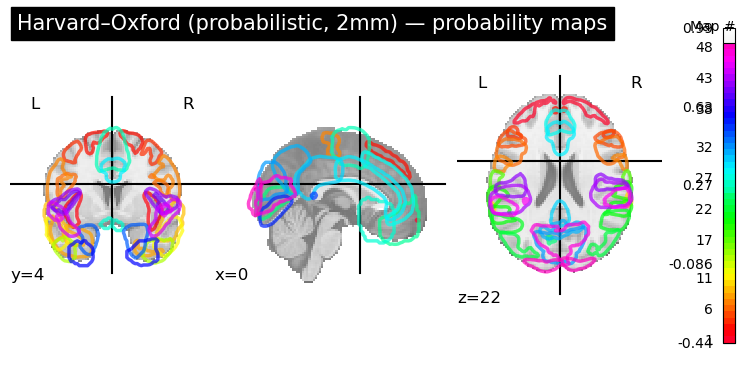

In [16]:
HOA_prob = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
prob_path = HOA_prob.maps  # 4D NIfTI
plotting.plot_prob_atlas(
    prob_path,
    title="Harvard–Oxford (probabilistic, 2mm) — probability maps"
)
plotting.show()


---

# Creating a Region-Based Mask (and using Maskers)

## Concept (what a “masker” does)

**Maskers** are nilearn objects that convert brain images (3D/4D NIfTI) into **clean numeric matrices** ready for analysis—handling **masking, resampling, standardization, confound regression, filtering, and smoothing** in one place. They follow the scikit-learn pattern: **`fit()` → `transform()` → (optionally) `inverse_transform()`**. `transform()` returns arrays of shape `(time, features)` for 4D input (or `(features,)` for 3D). 

---

## Two ways to define *regions* in nilearn

* **Labels (parcellations):** one 3D label image; each voxel has an integer region ID (**non-overlapping**, binary). Use **`NiftiLabelsMasker`**.
* **Maps (probabilistic):** one 4D image (one 3D map per region) with **weights**; regions **can overlap**. Use **`NiftiMapsMasker`**.

---

## The main maskers you’ll use (and when)

* **`NiftiMasker`** — voxel-level extraction inside a **binary mask** (e.g., a single ROI or whole-brain). Can auto-compute a brain mask via `mask_strategy` (`'background'`, `'epi'`, `'whole-brain-template'`, `'gm-template'`, `'wm-template'`). Good for **seed-based** workflows or when you want **voxel time series**. 
* **`NiftiLabelsMasker`** — ROI-level extraction from a **labels/parcellation** image (**non-overlapping** ROIs). Returns **one time series per region** (e.g., AAL, Harvard-Oxford). 
* **`NiftiMapsMasker`** — ROI-level extraction from **probabilistic/overlapping maps** (4D). Useful with network maps (e.g., Smith ICA). 
* **`NiftiSpheresMasker`** — ROI extraction from **MNI coordinates + radius** (spherical seeds). Great for hypothesis-driven seeds. 

In [5]:
import numpy as np, pandas as pd, nibabel as nib
from nilearn import image, plotting, datasets
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker, NiftiMapsMasker, NiftiSpheresMasker

# ----------------------------
# ===========================================
# Load functional data with nibabel + get TR
# ===========================================

# 1) Your functional file (Windows path → use a raw string r"...")
FUNC = r"H:\ML.neuroimaging\teaching\S 10\data\func\scap\swausub-10159_task-stopsignal_bold.nii"

# 2) Load NIfTI image
func_img = nib.load(FUNC)

# 3) Inspect basic info
print(func_img)                 # nibabel image object (filename, type)
print("Shape:", func_img.shape) # Expect 4D (X, Y, Z, T) for fMRI

TR = func_img.header.get_zooms()[3] 
# 5) Compute TR and number of time points

n_scans = func_img.shape[3]  # number of volumes (time points)

confounds = None  # (optional) DataFrame or array; pass later if you have it

print(f"TR (seconds): {TR:.6g}")
print(f"Number of volumes: {n_scans}")



<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 184)
affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  4  91 109  91 184   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  2.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'Warped - conv(8,8

## **A) **Single-region binary mask** → voxel-level time series (NiftiMasker)**

Use a **single label** from your atlas to build a **binary ROI mask**, then extract voxel time series; average them if you want one signal per region.

### 1) Choose the exact ROI name present in your atlas labels



In [59]:
TARGET_LABEL = "Precentral Gyrus"
HOA.labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

### 2) Convert ROI NAME -> label index 

In [65]:
atlas_img = image.load_img(atlas_img)
region_id = list(labels).index(TARGET_LABEL)
region_id

7

### 3) Build a binary mask image for that region

numerical representation of our mask:[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


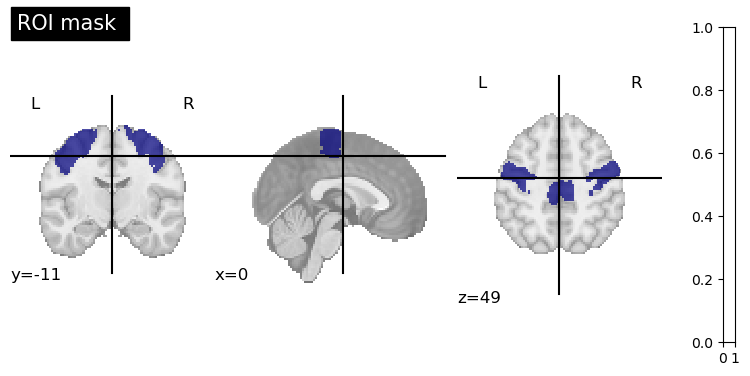

In [82]:
region_mask = (atlas_data == region_id).astype(np.int16)
print(f'numerical representation of our mask:{ region_mask}')
region_mask_img = nib.Nifti1Image(region_mask, atlas_img.affine, atlas_img.header)
plotting.plot_roi(region_mask_img, title="ROI mask ")
plotting.show()

### 4) Extract voxel-wise time series inside the region

## What is `X_vox`?


* **Shape** = `(T, V)`

  * **Rows (axis 0)** = **time points** in your fMRI run (number of volumes).

    * Row `i` corresponds to the signal at **time ≈ i × TR (seconds)**.
  * **Columns (axis 1)** = **voxels inside your ROI mask** **after** the mask has been resampled to the functional image’s space.

    * Column `j` is one specific voxel within the ROI.

* **Values** = the **standardized** BOLD signal at that time & voxel.

  * Because `standardize=True`, **each column** (each voxel) has **mean 0 and unit variance** over time (after confound regression if provided).
  * Units are **z-scored signal**, so values are dimensionless.

* **Confounds (optional)**

  * If you pass `confounds=...`, nilearn regresses them out **before** standardization (e.g., motion parameters, WM/CSF, etc.).
  * If `confounds=None`, you get raw signals (still standardized per voxel over time).

---

## What does `pd.DataFrame(X_vox)` show?

* A table with **T rows** (time points) and **V columns** (voxels).
* Default index: `0..T-1` (scan number).
* Default columns: `0..V-1` (voxel number within the ROI).
* Each cell = z-scored signal at that **time** and **voxel**.



In [83]:
masker_vox = NiftiMasker(
    mask_img=region_mask_img,
    standardize=True,          # z-score time series
    t_r=TR
)
X_vox = masker_vox.fit_transform(FUNC, confounds=confounds)  # shape: (time, n_voxels)
print("Voxel-wise shape:", X_vox.shape)
pd.DataFrame(X_vox)

Voxel-wise shape: (184, 8573)


,0,1,2,3,4,5,6,7,8,9,...,8563,8564,8565,8566,8567,8568,8569,8570,8571,8572
0,3.238251,2.876388,2.480556,1.869457,1.252228,1.097460,2.101838,2.073012,2.211627,1.779303,...,-0.600471,-0.982939,-0.003654,0.014352,-0.171163,-0.629567,-0.924017,-1.480950,-1.123057,-1.566445
1,2.600651,1.937437,1.380079,0.577109,-0.301098,-0.568900,1.461543,1.113832,0.761380,-0.014624,...,-1.245340,-1.444319,-0.339999,-0.513661,-0.736935,-1.036737,-1.136275,-1.480950,-1.468325,-1.745245
2,1.963051,1.311469,0.554722,-0.284456,-0.991466,-1.023362,1.141395,0.474379,-0.108769,-0.687347,...,-1.460296,-1.213629,-0.676344,-0.689666,-0.925525,-1.036737,-1.136275,-1.262079,-1.123057,-1.208844
3,1.963051,1.624453,1.104960,0.146326,-0.473690,-0.720387,0.821248,0.794106,0.761380,0.209617,...,-1.675252,-1.905699,-0.171827,-0.337657,-0.548344,-0.833152,-1.136275,-1.480950,-0.777790,-1.208844
4,1.325451,1.311469,0.554722,-0.069065,-0.646282,-0.871875,0.821248,0.794106,0.181281,-0.238865,...,-1.675252,-1.675009,-0.508171,-0.689666,-0.925525,-1.036737,-1.348533,-1.699822,-1.295691,-1.566445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.587350,-0.253449,0.279603,1.223283,1.770004,2.157870,0.501100,0.794106,0.761380,1.106581,...,1.334135,1.093271,-0.508171,-0.161653,0.206018,0.591942,0.561789,0.488894,0.258013,0.221558
180,-1.543750,-1.818368,-1.646231,-1.146021,-0.646282,-0.417413,-0.779490,-0.804527,-0.978917,-0.911588,...,0.259354,0.170511,-1.517206,-1.393684,-1.114116,-0.833152,-0.499501,-0.167721,-0.950424,-0.672443
181,-1.862550,-1.818368,-2.196470,-2.222978,-2.027017,-1.780798,-0.779490,-1.124253,-1.559016,-1.808552,...,-1.245340,-1.444319,-2.358068,-2.273706,-2.245658,-1.851076,-1.348533,-0.824335,-1.295691,-0.851244
182,-0.268550,-0.879417,-1.371112,-1.792195,-1.681833,-1.477823,1.141395,0.474379,-0.398818,-1.135829,...,-0.600471,-0.521559,-1.853551,-1.569688,-1.114116,-0.425982,-0.074985,0.270023,-0.087255,0.400358


### 5) Optional: average voxels to get one regional signal

In [84]:
import matplotlib as plt
roi_signal = X_vox.mean(axis=1)  # shape: (time,)
print("ROI signal shape:", roi_signal.shape)
pd.DataFrame(roi_signal)


ROI signal shape: (184,)


,0
0,0.207351
1,0.014346
2,-0.105400
3,-0.249056
4,-0.988954
...,...
179,-0.430606
180,-1.405371
181,-1.369874
182,-0.899288


### 6) Quick visual check

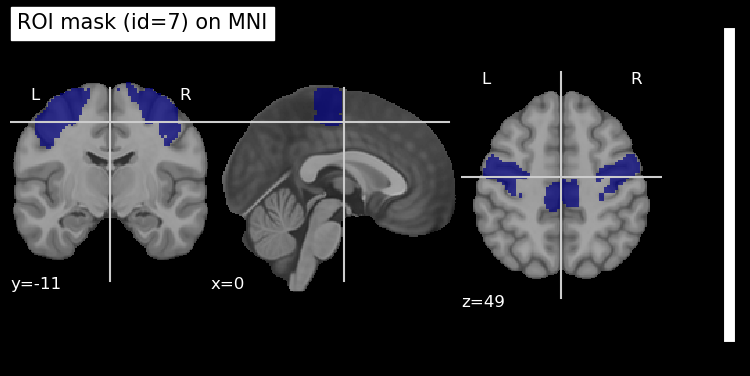

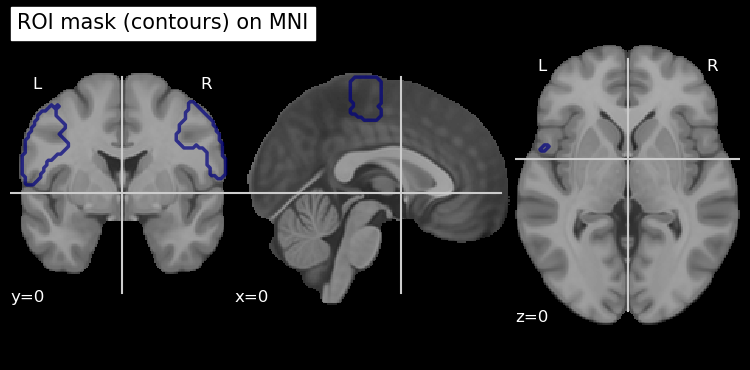

C:\Users\Saye\AppData\Local\Temp\ipykernel_11972\540169311.py:12: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_func = image.mean_img(FUNC)


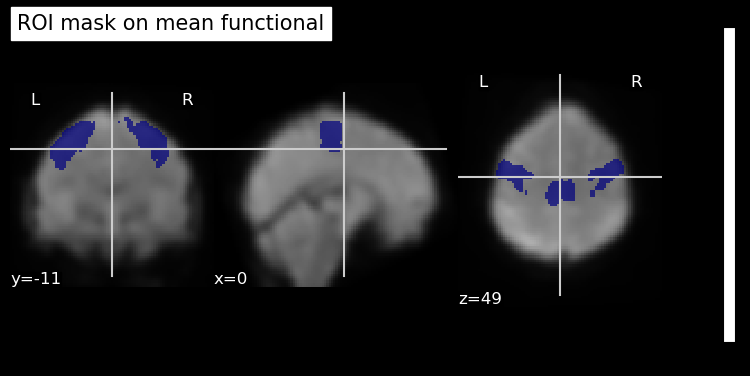

In [85]:
# Option 1 — overlay mask on a standard MNI T1 template
bg = datasets.load_mni152_template()
plotting.plot_roi(region_mask_img, bg_img=bg, title=f"ROI mask (id={region_id}) on MNI")
plotting.show()

# Option 2 — same overlay but as contours (nice for teaching slides)
plotting.plot_roi(region_mask_img, bg_img=bg, view_type="contours",
                  title="ROI mask (contours) on MNI")
plotting.show()

# Option 3 — overlay mask on your subject's mean functional (if FUNC is defined)
mean_func = image.mean_img(FUNC)
plotting.plot_roi(region_mask_img, bg_img=mean_func, title="ROI mask on mean functional")
plotting.show()


> If you **don’t** have a mask and want nilearn to make a brain mask, you can do:
> `NiftiMasker(mask_strategy="epi" or "background", t_r=TR, standardize=True).fit_transform(FUNC)` and inspect `masker.mask_img_` or `masker.generate_report()`.

---

## **B) **Parcellation (labels)** → one time series per ROI (NiftiLabelsMasker)**

Use when you want **region-level** signals for **all atlas ROIs** (non-overlapping).

In [139]:
labels_masker = NiftiLabelsMasker(
    labels_img=atlas_img,      # your labels/parcellation image
    standardize=True,
    t_r=TR,
    labels= HOA.labels
    # strategy='mean'  # default aggregation; can set 'median' in newer versions
)
TS_rois = labels_masker.fit_transform(FUNC, confounds=confounds)  # (time, n_rois)
print("ROI matrix shape:", TS_rois.shape)

region_names= labels_masker.region_names_
df_rois=pd.DataFrame(TS_rois, columns = region_names.values())
df_rois

ROI matrix shape: (184, 48)


,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole
0,1.822602,0.311012,1.893724,1.687779,1.036754,1.134671,0.477716,1.587041,0.836088,1.021941,...,0.506235,1.791679,0.237750,0.652145,0.730625,0.631801,0.921544,1.361207,1.244580,1.433799
1,1.136615,-0.203898,0.710050,0.726356,0.286745,0.196974,-0.000109,1.248792,0.377577,0.257448,...,-0.055417,0.830343,0.045456,-0.282751,0.048712,0.494277,-0.486281,0.231596,-0.538018,1.083606
2,0.205864,-0.602246,0.250560,0.246482,0.026278,0.303469,-0.166984,0.109606,-0.696194,-1.049695,...,-0.021931,-0.243933,-0.028762,-0.635468,-0.680731,-0.793597,-1.485814,-0.874921,-0.811227,-0.118614
3,-0.009094,-0.367316,0.459426,0.529004,-0.182526,0.222874,-0.287982,0.021998,-0.803196,-1.637893,...,0.201779,-1.030546,-0.146416,-0.363557,-0.738047,-0.415001,-1.234443,-1.023922,-1.506758,-1.435000
4,0.173052,-0.114960,-0.028053,0.147283,-0.060186,0.372159,-1.493016,0.254367,-0.403348,-1.007260,...,-0.651741,-1.746189,0.119675,-0.654562,-1.197408,0.112714,-0.706788,-0.928881,-2.810276,-2.515458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.998044,-1.868544,-0.455289,-0.672230,-0.254639,-0.303806,-0.609324,-2.162503,-1.722565,-1.098193,...,0.064751,1.654062,-0.942578,-1.367667,-1.077745,-2.210096,-1.348601,-1.163597,1.068533,1.809474
180,-2.217445,-2.679052,-1.376141,-1.554303,-1.131653,-0.672032,-2.221292,-2.712116,-2.663992,-2.763661,...,-1.243553,1.261026,-1.443553,-2.636017,-3.433827,-2.634263,-2.439981,-3.418600,-0.782367,1.660583
181,-2.614961,-3.215648,-1.412960,-1.828744,-1.563971,-1.857787,-2.337429,-3.124310,-3.391885,-3.719196,...,-1.840827,0.739019,-2.126701,-3.527101,-3.966720,-3.317300,-3.460710,-4.233554,-1.642401,0.769186
182,-2.537959,-2.761536,-1.298761,-1.639851,-1.677343,-1.729897,-1.592477,-3.568725,-3.134236,-3.024991,...,-1.198431,0.289783,-1.761090,-2.721426,-1.967112,-3.351546,-2.608801,-2.809494,-0.103191,0.009692


> **Implication:** every column = **one ROI’s time series**. Perfect for **ROI-to-ROI connectivity** or GLM with region summaries. 

### 1) Visualize the parcellation on the data


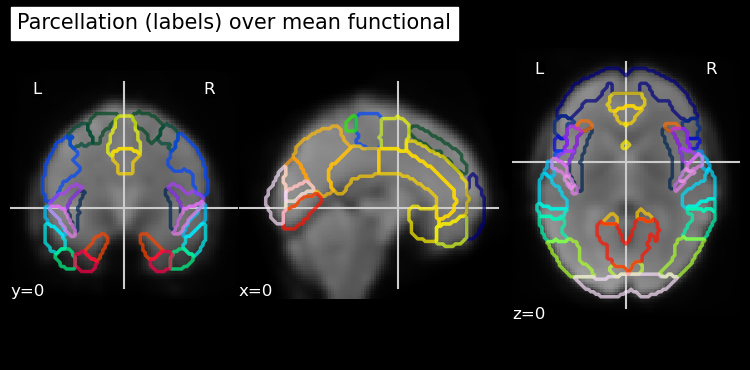

In [140]:
# Overlay atlas (labels) as contours on your mean functional
plotting.plot_roi(
    atlas_img,
    bg_img=mean_func,
    view_type="contours",
    title="Parcellation (labels) over mean functional"
)
plotting.show()


### 2) Plot a few ROI time series (lines)

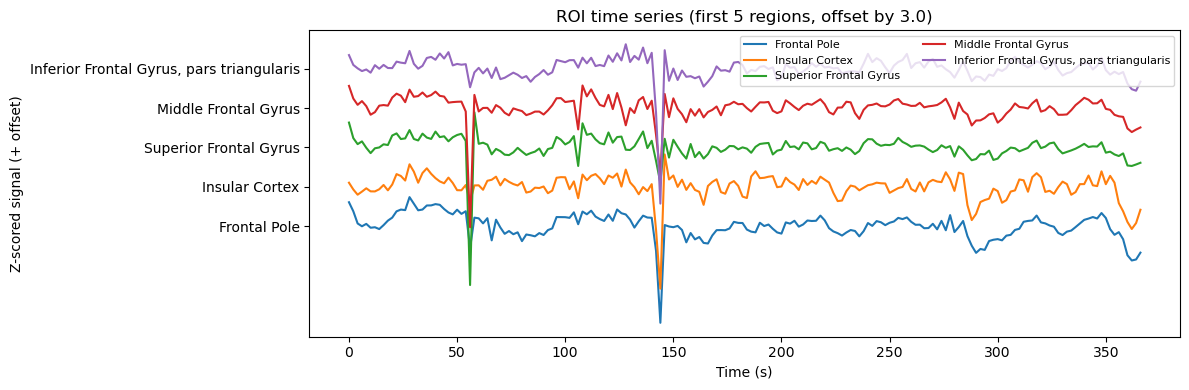

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image

# 1) Get label IDs in the SAME ORDER as TS_rois columns

names_list=list(region_names.values())
# 3) Build a nicely labeled DataFrame
df_rois = pd.DataFrame(TS_rois, columns=names_list)

# 4) Plot k ROI time series with vertical offsets; legend shows ROI NAMES
k = 5            # how many to show
t = np.arange(df_rois.shape[0]) * TR   # time in seconds
sep = 3.0                              # vertical separation (z-score units)

plt.figure(figsize=(12, 4))
for j, col in enumerate(df_rois.columns[:k]):
    plt.plot(t, df_rois[col].to_numpy() + j*sep, label=col)

plt.xlabel("Time (s)")
plt.ylabel("Z-scored signal (+ offset)")
plt.title(f"ROI time series (first {k} regions, offset by {sep})")
plt.yticks([j*sep for j in range(k)], list(df_rois.columns[:k]))  # label strips by ROI name
plt.legend(loc="upper right", ncol=2, fontsize=8)                 # <-- names in legend
plt.tight_layout()
plt.show()


In [113]:
names_list

['Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallosal Cortex',
 '

### 3) ROI-to-ROI correlation matrix (heatmap)

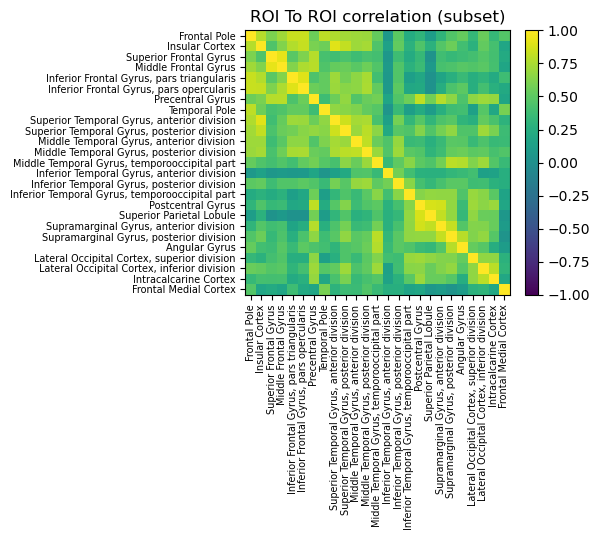

In [159]:
corr = np.corrcoef(TS_rois.T)  # n_maps x n_maps
max_show = min(25, corr.shape[0])
corr_sub = corr[:max_show, :max_show]
names_sub = df_rois.columns[:max_show]

plt.figure(figsize=(6.5, 5.5))
im = plt.imshow(corr_sub, vmin=-1, vmax=1, interpolation="nearest")
plt.title("ROI To ROI correlation (subset)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(max_show), names_sub, rotation=90, fontsize=7)
plt.yticks(range(max_show), names_sub, fontsize=7)
plt.tight_layout()
plt.show()


---

## **C) **Probabilistic/overlapping maps** → weighted ROI signals (NiftiMapsMasker)**

Use with **4D probabilistic atlases** (e.g., Harvard-Oxford probabilistic, Smith networks). Regions may **overlap**; signals are **weighted** by map values.

In [130]:
# Fetch a probabilistic atlas (example)
ho_prob = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
maps_img = image.load_img(ho_prob.maps)  # 4D, one map per region

maps_masker = NiftiMapsMasker(
    maps_img=maps_img,
    standardize=True,
    t_r=TR
)
TS_maps = maps_masker.fit_transform(FUNC, confounds=confounds)  # (time, n_maps)
print("Maps-based ROI matrix shape:", TS_maps.shape)

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl
Maps-based ROI matrix shape: (184, 48)


In [156]:
region_names= labels_masker.region_names_
df_maps=pd.DataFrame(TS_maps, columns = region_names.values())
df_maps

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole
0,1.771604,0.255884,1.920326,1.605542,0.707674,1.065041,0.250200,1.647943,0.799027,0.792130,...,-0.058100,2.268570,-0.009238,0.561621,0.300401,0.537664,0.767094,1.507220,-0.653433,1.426906
1,1.123643,-0.257262,0.704652,0.699001,0.085960,0.118705,0.057956,1.288623,0.254535,0.275627,...,-0.242211,1.388379,0.094288,-0.468971,0.497506,0.571560,-0.793661,0.345968,-1.883500,1.216465
2,0.219140,-0.564245,0.248604,0.251867,-0.082227,0.317336,-0.149392,0.195779,-0.422523,-1.080602,...,0.143175,0.052592,0.154355,-0.492128,-0.491284,-0.732189,-1.758405,-0.782757,-0.872257,-0.048611
3,-0.033609,-0.302930,0.395495,0.585860,-0.359030,0.345068,-0.315228,0.077496,-0.638318,-1.860965,...,0.721302,-0.873887,0.076923,-0.134165,-0.624561,-0.296552,-1.574755,-0.931648,-0.697145,-1.450125
4,0.178914,-0.111894,-0.040129,0.211755,-0.370176,0.807571,-1.618088,0.298875,-0.306106,-1.091940,...,-0.136158,-1.496598,0.349779,-0.507085,-1.339446,0.249488,-0.924729,-0.862191,-1.614972,-2.462938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.995183,-1.843969,-0.372070,-0.661603,0.025805,-0.157067,-0.646761,-2.113230,-1.718534,-1.044121,...,-0.435377,1.746592,-1.100212,-1.208458,-0.428359,-2.242869,-1.232270,-1.128188,-0.357387,1.812529
180,-2.221869,-2.637626,-1.196485,-1.489318,-0.884487,-0.121134,-2.108054,-2.624884,-2.604616,-2.559135,...,-1.601165,1.903612,-1.369829,-2.262454,-2.416201,-2.648724,-2.073625,-3.531668,-1.617442,1.879603
181,-2.616622,-3.077030,-1.246084,-1.784967,-1.135564,-1.511498,-2.078545,-3.020962,-3.289439,-3.232677,...,-1.996568,1.379684,-1.816625,-3.242340,-2.670512,-3.203387,-3.223612,-4.326674,-0.893825,1.032663
182,-2.554741,-2.680859,-1.186359,-1.578547,-1.370259,-1.551618,-1.427620,-3.494558,-3.040321,-2.773361,...,-1.206687,0.297298,-1.414228,-2.468883,-0.364229,-3.338449,-2.268041,-2.839670,1.376644,0.050913


### 1) Overview: visualize the whole atlas

C:\Users\Saye\AppData\Local\Temp\ipykernel_11972\2350873732.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_func = image.mean_img(FUNC)


maps_img shape: (91, 109, 91, 48)
n maps (labels): 49


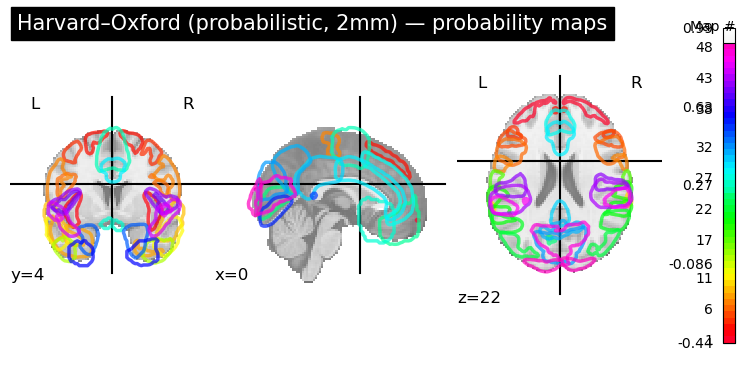

In [148]:
maps_img = image.load_img(ho_prob.maps)   # 4D
mean_func = image.mean_img(FUNC)

# Region names in the same order as 4D maps
names_list = [str(n) for n in getattr(ho_prob, "labels", [])]
print("maps_img shape:", maps_img.shape)
print("n maps (labels):", len(names_list))

# =======================================

# =======================================
# Shows several probability maps at once (nice for teaching)
plotting.plot_prob_atlas(
    maps_img,
    title="Harvard–Oxford (probabilistic, 2mm) — probability maps"
)
plotting.show()

### 2) Overlay a few individual maps on your mean EPI

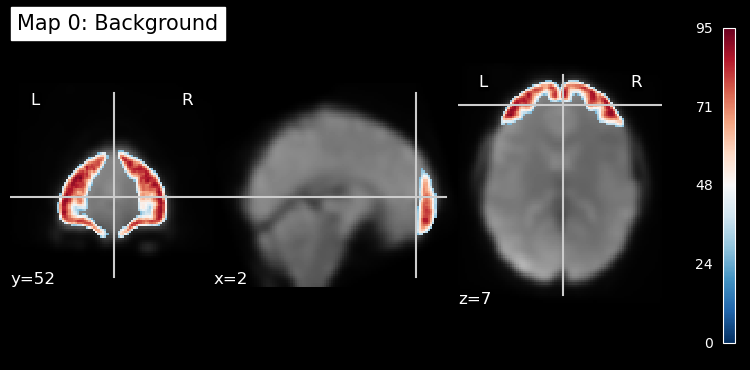

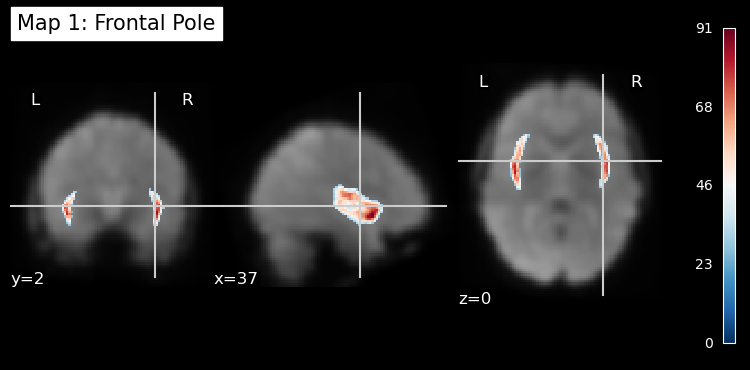

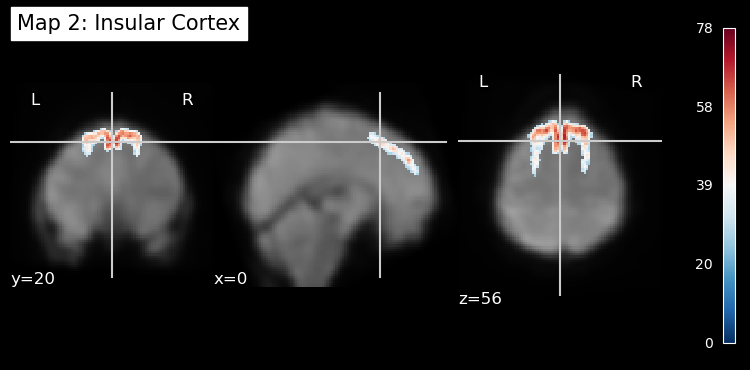

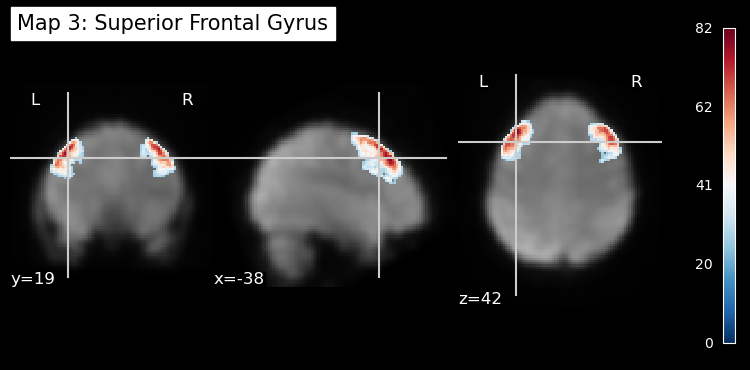

In [149]:

# Pick a few indices to show (edit as you like)
show_idx = [0, 1, 2, 3]  # first 4 maps

for idx in show_idx:
    one_map = image.index_img(maps_img, idx)  # 3D map
    # Slight threshold for display (probabilities are 0..100 or 0..1 depending on atlas);
    # many HO prob atlases are in percentage; using > 25 is a common pedagogical choice.
    thr_map = image.math_img("img * (img > 25)", img=one_map)  # adjust threshold if needed
    plotting.plot_stat_map(
        thr_map, bg_img=mean_func, threshold=0,
        display_mode="ortho", title=f"Map {idx}: {names_list[idx] if idx < len(names_list) else idx}"
    )
    plotting.show()


### 3) Plot a few map time series with vertical offsets

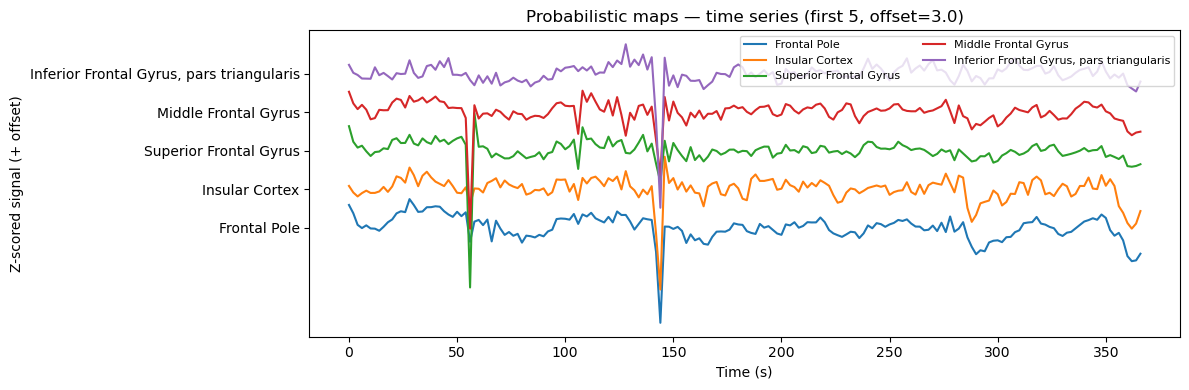

In [157]:

k = min(5, df_maps.shape[1])        # how many to show
idxs = list(range(k))               # first k maps (edit as needed)
t = np.arange(df_maps.shape[0]) * TR
sep = 3.0                           # vertical separation (z-score units)

plt.figure(figsize=(12, 4))
for j, col_idx in enumerate(idxs):
    col_name = df_maps.columns[col_idx]
    plt.plot(t, df_maps[col_name].to_numpy() + j*sep, label=col_name)

plt.xlabel("Time (s)")
plt.ylabel("Z-scored signal (+ offset)")
plt.title(f"Probabilistic maps — time series (first {k}, offset={sep})")
plt.yticks([j*sep for j in idxs], [df_maps.columns[i] for i in idxs])
plt.legend(loc="upper right", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


### 4) ROI-to-ROI correlation heatmap (subset)

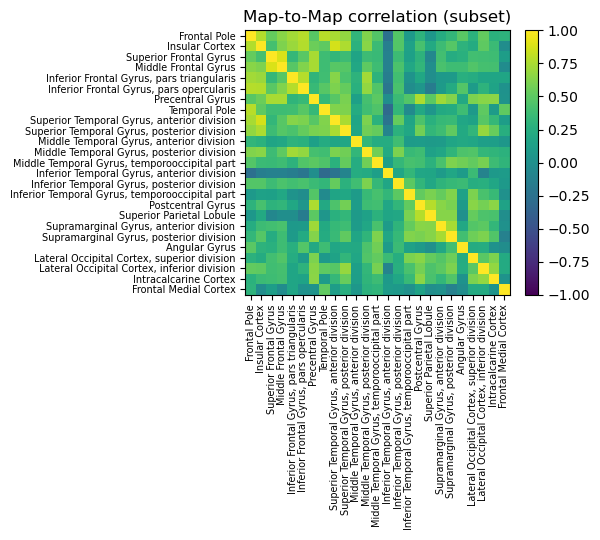

In [158]:

corr = np.corrcoef(TS_maps.T)  # n_maps x n_maps
max_show = min(25, corr.shape[0])
corr_sub = corr[:max_show, :max_show]
names_sub = df_maps.columns[:max_show]

plt.figure(figsize=(6.5, 5.5))
im = plt.imshow(corr_sub, vmin=-1, vmax=1, interpolation="nearest")
plt.title("Map-to-Map correlation (subset)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(max_show), names_sub, rotation=90, fontsize=7)
plt.yticks(range(max_show), names_sub, fontsize=7)
plt.tight_layout()
plt.show()


---



## **D) **Spherical seeds** (coordinates) → seed signals (NiftiSpheresMasker)**

Use for **hypothesis-driven seeds** (MNI coordinates + radius). 

In [160]:
seeds = [(-42, -24, 52)]  # e.g., left M1; add more tuples for multiple seeds
spheres_masker = NiftiSpheresMasker(
    seeds=seeds, radius=6,    # mm
    standardize=True,
    t_r=TR
)
TS_seeds = spheres_masker.fit_transform(FUNC, confounds=confounds)  # (time, n_seeds)
print("Seed time series shape:", TS_seeds.shape)

Seed time series shape: (184, 1)


C:\Users\Saye\AppData\Local\Temp\ipykernel_11972\4021464995.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_func = image.mean_img(FUNC)  # background for plotting


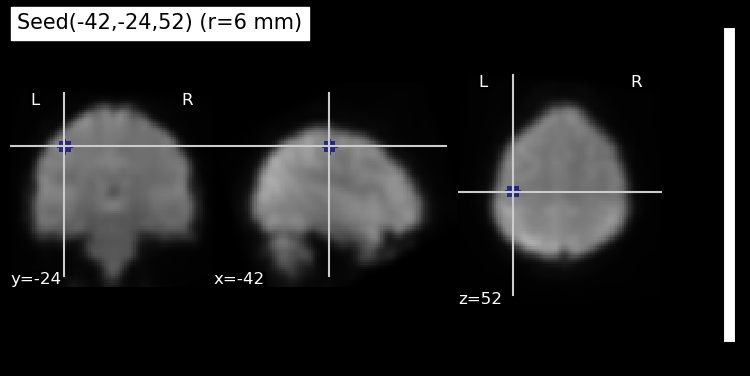

In [162]:
# Edit/extend as you like (add more tuples for more seeds)
seeds = [(-42, -24, 52)]  # e.g., left M1
seed_names = [f"Seed({x},{y},{z})" for (x,y,z) in seeds]  # legend-friendly labels

mean_func = image.mean_img(FUNC)  # background for plotting



# ===========================================
# 1) Visualize spheres on your mean EPI
#    (draws actual spherical masks for each seed)
# ===========================================
def make_sphere_img(center_mni, radius_mm, ref_img):
    """Create a binary spherical mask (NIfTI) at MNI coords using ref_img grid."""
    arr = np.zeros(ref_img.shape[:3], dtype=np.int16)
    ijk = np.indices(arr.shape).reshape(3, -1).T
    xyz = nib.affines.apply_affine(ref_img.affine, ijk)
    dist = np.linalg.norm(xyz - np.array(center_mni), axis=1)
    arr_flat = (dist <= radius_mm).astype(np.int16)
    arr = arr_flat.reshape(arr.shape)
    return nib.Nifti1Image(arr, ref_img.affine, ref_img.header)

radius_mm = 6  # same radius you’ll use in the masker
for name, center in zip(seed_names, seeds):
    sphere_img = make_sphere_img(center, radius_mm, mean_func)
    plotting.plot_roi(sphere_img, bg_img=mean_func,
                      title=f"{name} (r={radius_mm} mm)")
    plotting.show()


In [ ]:
# ===========================================
# 2) Extract seed time series with NiftiSpheresMasker
# ===========================================
spheres_masker = NiftiSpheresMasker(
    seeds=seeds,
    radius=radius_mm,
    standardize=True,
    t_r=TR
)
TS_seeds = spheres_masker.fit_transform(FUNC, confounds=confounds)  # (time, n_seeds)
print("Seed time series shape (time, n_seeds):", TS_seeds.shape)

df_seeds = pd.DataFrame(TS_seeds, columns=seed_names)
df_seeds.head()


Seed time series shape (time, n_seeds): (184, 1)


,"Seed(-42,-24,52)"
0,-0.507301
1,-1.399679
2,-0.507301
3,-0.150349
4,-1.756631


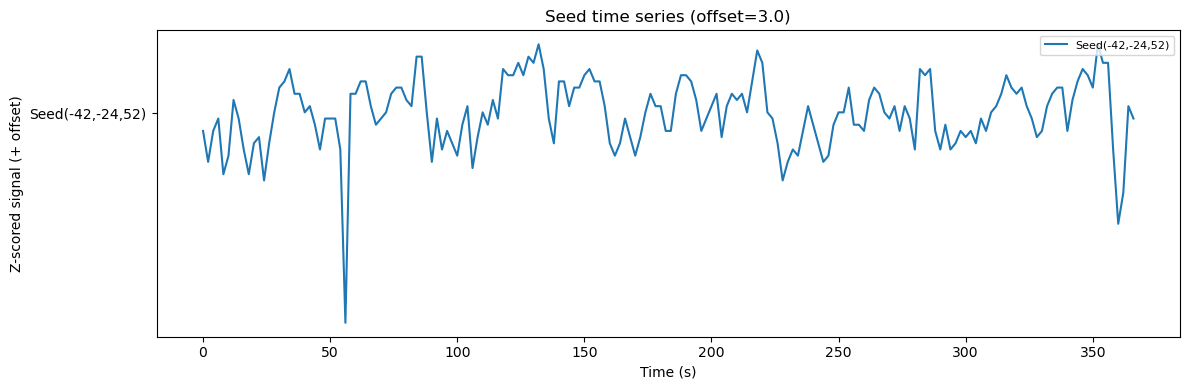

In [164]:
# ===========================================
# 3) Plot seed time series with vertical offsets
# ===========================================
t = np.arange(df_seeds.shape[0]) * TR   # seconds
sep = 3.0                               # vertical separation (z-score units)

plt.figure(figsize=(12, 4))
for j, col in enumerate(df_seeds.columns):
    plt.plot(t, df_seeds[col].to_numpy() + j*sep, label=col)

plt.xlabel("Time (s)")
plt.ylabel("Z-scored signal (+ offset)")
plt.title(f"Seed time series (offset={sep})")
plt.yticks([j*sep for j in range(len(df_seeds.columns))], list(df_seeds.columns))
plt.legend(loc="upper right", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


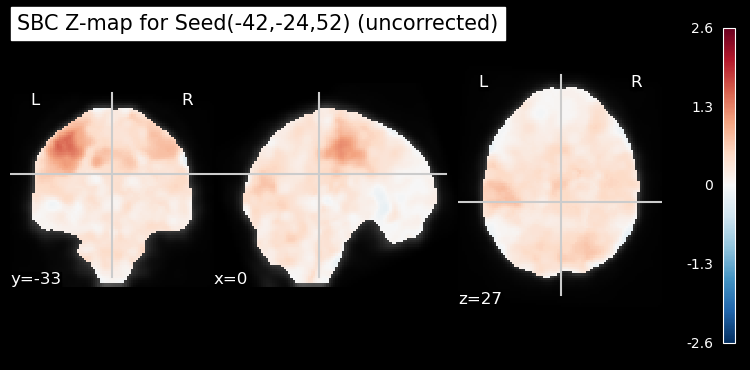

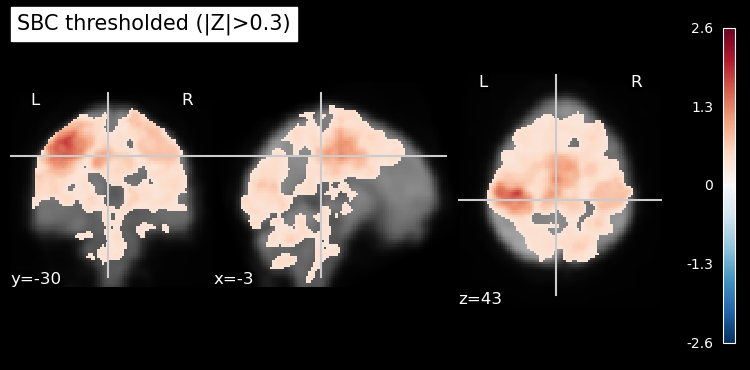

In [ ]:
# ===========================================
# 4) Seed-based correlation (whole-brain SBC) map
#    (uses the FIRST seed; duplicate for others if needed)
# ===========================================
# Create a whole-brain masker from the functional (auto brain mask from EPI)
whole_masker = NiftiMasker(
    standardize=True, t_r=TR, mask_strategy="epi"  # robust for fMRI
)
whole_ts = whole_masker.fit_transform(FUNC, confounds=confounds)  # (time, n_voxels)

# Correlate each voxel with the chosen seed time series
seed_idx = 0                        # choose which seed to map
seed_ts  = TS_seeds[:, seed_idx]    # (time,)
seed_ts_c = seed_ts - seed_ts.mean()
vox_ts_c  = whole_ts - whole_ts.mean(axis=0)
num = vox_ts_c.T @ seed_ts_c
den = (len(seed_ts_c) - 1) * (seed_ts_c.std(ddof=1) * whole_ts.std(axis=0, ddof=1) + 1e-12)
r = (num / den).astype(np.float32)  # correlation per voxel

# Back to NIfTI image and Fisher Z (for display)
r_img = whole_masker.inverse_transform(r)
z_img = image.math_img("np.arctanh(np.clip(img, -0.999999, 0.999999))", img=r_img)

# Show raw Z map and a lightly thresholded version
plotting.plot_stat_map(z_img, bg_img=mean_func,
                       title=f"SBC Z-map for {seed_names[seed_idx]} (uncorrected)")
plotting.show()

thr = 0.3
# put the numeric constant inside the expression string
z_thr = image.math_img(f"img * (np.abs(img) > {thr})", img=z_img)

plotting.plot_stat_map(z_thr, bg_img=mean_func,
                       title=f"SBC thresholded (|Z|>{thr})")
plotting.show()



## Quick “when to use what”

* **Want one signal per atlas ROI (non-overlap)?** → `NiftiLabelsMasker`.
* **Have probabilistic/overlapping networks?** → `NiftiMapsMasker`. 
* **Single ROI or voxel-level inside a binary mask?** → `NiftiMasker` (you can average after). 
* **Have coordinates (MNI) for seeds?** → `NiftiSpheresMasker`. 

---

## **E) Custom ROI Mask (NIfTI) → Extracting Time Series & Masking Functional Data**


### 1) Load the mask NIfTI (SMA_R-L) and binarize

In [3]:
mask_path = r"H:\ML.neuroimaging\teaching\S 10\data\SMA_R-L.nii"
# Load via nilearn (accepts path or image)
mask_img_raw = image.load_img(mask_path)

# Binarize (>0) to ensure it's a proper mask image
mask_img_bin = image.math_img("(img > 0).astype('int16')", img=mask_img_raw)

print("Mask loaded from:", mask_path)
print("Mask (original) shape:", mask_img_raw.shape, "| after binarize:", mask_img_bin.shape)


Mask loaded from: H:\ML.neuroimaging\teaching\S 10\data\SMA_R-L.nii
Mask (original) shape: (91, 109, 91) | after binarize: (91, 109, 91)


### 2) Resample the mask to the functional grid  (keeps labels using nearest-neighbor)

C:\Users\Saye\AppData\Local\Temp\ipykernel_4072\4283262862.py:1: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  mask_in_func = image.resample_to_img(mask_img_bin, func_img, interpolation='nearest')
C:\Users\Saye\AppData\Local\Temp\ipykernel_4072\4283262862.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mask_in_func = image.resample_to_img(mask_img_bin, func_img, interpolation='nearest')
C:\Users\Saye\AppData\Local\Temp\ipykernel_4072\4283262862.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behav

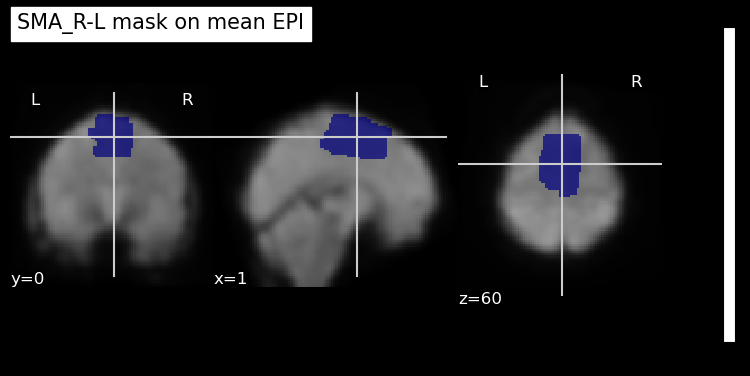

In [6]:
mask_in_func = image.resample_to_img(mask_img_bin, func_img, interpolation='nearest')

# Quick overlay on mean functional to verify alignment
mean_func = image.mean_img(func_img)
plotting.plot_roi(mask_in_func, bg_img=mean_func, title="SMA_R-L mask on mean EPI")
plotting.show()

### 3) Extract voxel-wise and mean ROI time series

In [7]:
from nilearn.maskers import NiftiMasker

masker_vox = NiftiMasker(
    mask_img=mask_in_func,
    standardize=True,
    t_r=TR
)

X_vox = masker_vox.fit_transform(FUNC, confounds=confounds)  # (time, n_voxels-in-ROI)
print("Voxel-wise matrix shape (time, n_voxels):", X_vox.shape)

# Mean ROI signal (time,)
roi_signal = X_vox.mean(axis=1)
print("Mean ROI signal shape:", roi_signal.shape)

# Nice DataFrame with time in seconds and labeled voxel columns
t_sec = np.arange(X_vox.shape[0]) * TR
df_vox = pd.DataFrame(X_vox, index=t_sec,
                      columns=[f"voxel_{j:04d}" for j in range(X_vox.shape[1])])
df_vox.index.name = "time_s"
df_vox.head()

Voxel-wise matrix shape (time, n_voxels): (184, 7262)
Mean ROI signal shape: (184,)


,voxel_0000,voxel_0001,voxel_0002,voxel_0003,voxel_0004,voxel_0005,voxel_0006,voxel_0007,voxel_0008,voxel_0009,...,voxel_7252,voxel_7253,voxel_7254,voxel_7255,voxel_7256,voxel_7257,voxel_7258,voxel_7259,voxel_7260,voxel_7261
time_s,,,,,,,,,,,,,,,,,,,,,
0.0,1.257534,1.470037,1.752303,2.087684,1.287582,1.318326,1.572857,1.695543,1.027793,1.093206,...,-0.323443,0.020833,0.530343,0.223786,0.348233,0.420044,1.130046,0.905890,0.892960,1.047631
2.0,1.052767,0.921010,1.047554,0.992768,0.887727,0.773628,0.853836,0.917054,0.421013,0.523376,...,-0.503245,-0.161698,-0.400503,-0.424666,-0.160304,0.067130,-0.008504,-0.004119,0.244815,0.379470
4.0,0.233700,0.554992,0.695179,0.627796,0.287945,0.592062,0.674081,0.722432,0.016493,0.333433,...,0.395763,0.568427,0.375202,0.385899,0.517746,0.596500,0.560771,0.602554,0.730924,0.880591
6.0,0.643233,0.554992,0.518991,0.445311,0.487872,0.228930,0.134816,-0.056056,0.421013,0.143489,...,0.036160,0.568427,-0.245362,-0.100440,0.178721,0.596500,0.133815,0.299217,0.568888,0.880591
8.0,0.643233,0.738001,0.518991,0.627796,0.487872,0.410496,0.314571,0.333188,0.016493,-0.046454,...,-0.503245,-0.344229,-0.400503,-0.262553,-0.160304,-0.109327,-0.150823,-0.004119,-0.079258,0.212430


### 4) Plot a few voxel time series with offsets

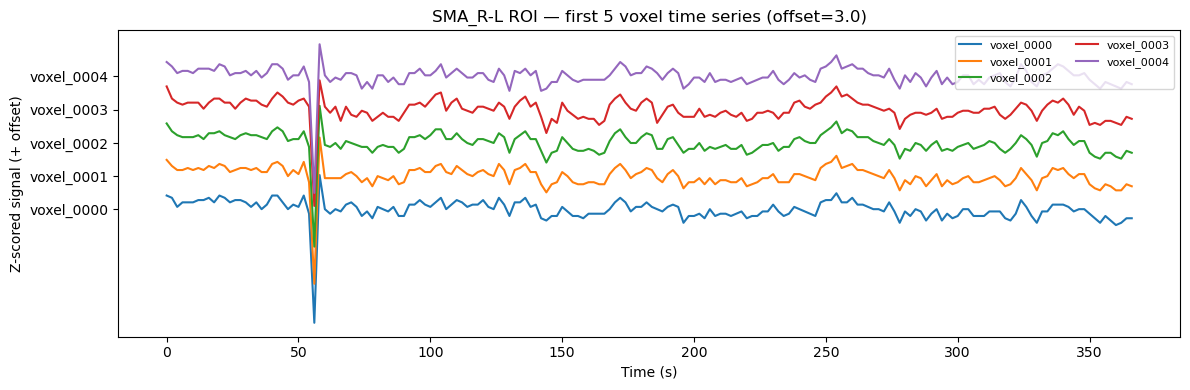

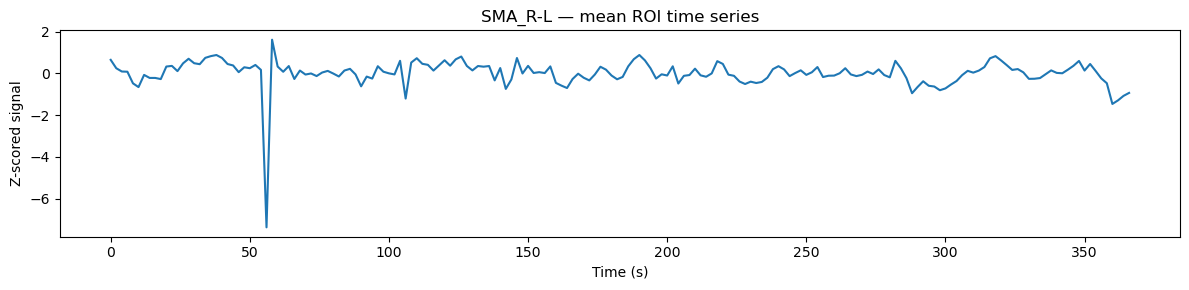

In [8]:
import matplotlib.pyplot as plt

k = min(5, X_vox.shape[1])  # show first k voxels
sep = 3.0                   # vertical separation (z-score units)

plt.figure(figsize=(12, 4))
for j in range(k):
    plt.plot(t_sec, X_vox[:, j] + j*sep, label=f"voxel_{j:04d}")

plt.xlabel("Time (s)")
plt.ylabel("Z-scored signal (+ offset)")
plt.title(f"SMA_R-L ROI — first {k} voxel time series (offset={sep})")
plt.yticks([j*sep for j in range(k)], [f"voxel_{j:04d}" for j in range(k)])
plt.legend(loc="upper right", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Mean ROI signal
plt.figure(figsize=(12, 3))
plt.plot(t_sec, roi_signal, label="ROI mean")
plt.xlabel("Time (s)")
plt.ylabel("Z-scored signal")
plt.title("SMA_R-L — mean ROI time series")
plt.tight_layout()
plt.show()

----

## What `inverse_transform` does (intuitively)

A masker (e.g., `NiftiMasker`) turns images → arrays with shape **(time, features)**, where **features = voxels inside the mask**.
`inverse_transform` does the **reverse**: it “paints” an array back into a NIfTI image on the original grid used by the masker:

* If you pass a **1D array** of length `n_features` → you get a **3D** image (one volume).
* If you pass a **2D array** of shape `(n_timepoints, n_features)` → you get a **4D** image (time series).
* Voxels **outside** the mask are filled with **0**.

> Important: if you set `standardize=True` when extracting, the values you paint back are **z-scored** (dimensionless), not raw BOLD intensities.

## When to use it

Use `masker.inverse_transform(...)` whenever you’ve computed something **on the extracted features** (voxels-in-mask, ROIs, or maps) and you want a **NIfTI image** for plotting, saving, or sending to other tools (FSL/SPM/ITK-SNAP).

Common moments:

1. **Visualize results you computed in feature space**

   * e.g., per-voxel correlations, betas, PCA loadings, feature importances → back to a 3D map.
2. **Sanity-check / QC**

   * Rebuild a **single time point** or a **time window** back to a 3D/4D NIfTI to verify alignment or preprocessing.
3. **Make shareable outputs**

   * Save derived maps (e.g., a **seed correlation map**, a **mean pattern** inside an ROI) as NIfTI for reports or other software.
4. **Parcellation summaries**

   * With `NiftiLabelsMasker`, turn a vector of **per-ROI values** (one per label) back into a labeled image (constant within each ROI).
5. **Probabilistic maps**

   * With `NiftiMapsMasker`, combine values with the atlas’ **overlapping maps** to make a weighted NIfTI image.

## Where in the workflow

* **Right after** `X = masker.fit_transform(...)` (feature extraction) and **after** you compute a vector/matrix that matches the feature dimensions:

  * `NiftiMasker`: features = **voxels in mask**
  * `NiftiLabelsMasker`: features = **ROIs (labels)**
  * `NiftiMapsMasker`: features = **maps (probabilistic components)**

----

# **TASKS**

# Task 1 — Warm-up (Easy): Make & visualize a binary ROI mask

**Goal.** Load the Harvard–Oxford atlas, pick one region (e.g., *Precentral Gyrus*), build a **binary mask**, count voxels, and overlay it on an MNI template.

**Steps for students**

1. Fetch the **Harvard–Oxford cortical atlas** (max-prob, 25%, 2 mm).
2. Find the label index for “Precentral Gyrus”.
3. Create a binary mask (1 = region, 0 = elsewhere).
4. Count mask voxels and plot the mask over the MNI152 template.

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl
ROI: Precentral Gyrus | label id: 7 | voxels: 8573


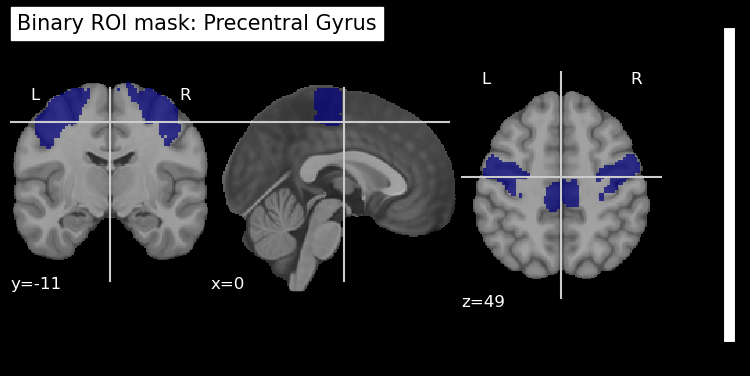

In [1]:
# --- Imports
import numpy as np, nibabel as nib, matplotlib.pyplot as plt
from nilearn import datasets, image, plotting

# 1) Fetch atlas (labels image) + names
HO = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_path = HO.filename           # 3D labels (int IDs)
labels     = list(HO.labels)       # region names (index = label ID)

# 2) Pick a region by name
TARGET = "Precentral Gyrus"
region_id = labels.index(TARGET)   # integer label in the atlas

# 3) Build binary mask (same grid as atlas)
atlas_img  = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()
mask_data  = (atlas_data == region_id).astype(np.int16)
mask_img   = nib.Nifti1Image(mask_data, atlas_img.affine, atlas_img.header)

# 4) Count voxels & visualize on MNI
voxel_count = int(mask_data.sum())
print(f"ROI: {TARGET} | label id: {region_id} | voxels: {voxel_count}")

bg = datasets.load_mni152_template()
plotting.plot_roi(mask_img, bg_img=bg, title=f"Binary ROI mask: {TARGET}")
plotting.show()


# Task 2 — Core (Medium): Extract ROI voxel time series (NiftiMasker)

**Goal.** Use your ROI mask to extract **voxel-wise time series** from real fMRI data; also compute a single **mean ROI signal**.

**Steps for students**

1. Download one subject from **ADHD** sample fMRI (public, auto-download).`datasets.fetch_adhd(n_subjects=1)`

2. Resample the ROI mask to the functional grid (nearest-neighbor).`image.resample_to_img(interpolation="nearest")`

3. Use **`NiftiMasker`** (`standardize=True`) to get `(time, n_voxels)` data.

4. Compute & plot the mean ROI signal.

[fetch_adhd] Dataset created in C:\Users\Saye\nilearn_data\adhd
[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7781/adhd40_metadata.tgz ...
[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from C:\Users\Saye\nilearn_data\adhd\fbef5baff0b388a8c913a08e1d84e059\adhd40_metadata.tgz...
[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7782/adhd40_0010042.tgz ...
Downloaded 827392 of 44414948 bytes (1.9%%,   52.9s remaining)
Downloaded 2449408 of 44414948 bytes (5.5%%,   35.1s remaining)
Downloaded 4120576 of 44414948 bytes (9.3%%,   29.8s remaining)
Downloaded 5758976 of 44414948 bytes (13.0%%,   27.3s remaining)
Downloaded 7217152 of 44414948 bytes (16.2%%,   26.1s remaining)
Downloaded 8912896 of 44414948 bytes (20.1%%,   24.2s remaining)
Downloaded 10403840 of 44414948 bytes (23.4%%,   23.2s remaining)
Downloaded 11812864 of 44414948 bytes (26.6%%,   22.4s remaining)
Downloaded 13533184 of 44

C:\Users\Saye\AppData\Local\Temp\ipykernel_7052\1068681273.py:15: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  mask_in_func = image.resample_to_img(mask_img, func_img, interpolation="nearest")
C:\Users\Saye\AppData\Local\Temp\ipykernel_7052\1068681273.py:15: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mask_in_func = image.resample_to_img(mask_img, func_img, interpolation="nearest")


Voxel matrix shape: (176, 2539)


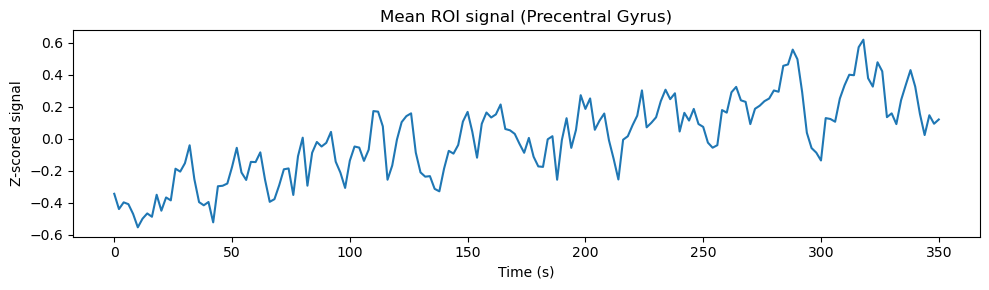

In [2]:
# --- Imports
import numpy as np, pandas as pd, nibabel as nib, matplotlib.pyplot as plt
from nilearn import datasets, image
from nilearn.maskers import NiftiMasker

# 1) Get ADHD sample (one subject)
adhd = datasets.fetch_adhd(n_subjects=1)
FUNC = adhd.func[0]
func_img = nib.load(FUNC)
TR = func_img.header.get_zooms()[3]
print("Func shape:", func_img.shape, "TR:", TR)

# -- Reuse the mask from Task 1 (mask_img)
# 2) Resample mask to functional grid
mask_in_func = image.resample_to_img(mask_img, func_img, interpolation="nearest")

# 3) Extract voxel time series
masker = NiftiMasker(mask_img=mask_in_func, standardize=True, t_r=TR)
X_vox = masker.fit_transform(FUNC)            # shape: (time, n_voxels)
print("Voxel matrix shape:", X_vox.shape)

# 4) Mean ROI signal + plot
t_sec = np.arange(X_vox.shape[0]) * TR
roi_signal = X_vox.mean(axis=1)

plt.figure(figsize=(10,3))
plt.plot(t_sec, roi_signal)
plt.xlabel("Time (s)"); plt.ylabel("Z-scored signal")
plt.title("Mean ROI signal (Precentral Gyrus)")
plt.tight_layout(); plt.show()


# Task 3 — Advanced (Medium-Hard): Parcellation time series & ROI-to-ROI correlations

**Goal.** Use **`NiftiLabelsMasker`** with the atlas to get **one time series per ROI**, then make a **correlation heatmap** and **inverse_transform** a per-ROI summary back to an image.

**Steps for students**

1. Load ADHD fMRI(same as what you did in task2) and the **Harvard–Oxford labels** atlas.
2. Extract ROI signals for **all labels** with `NiftiLabelsMasker(standardize=True)`.
3. Plot a small subset (e.g., first 5 ROIs) with vertical offsets.
4. Compute ROI-to-ROI **correlation matrix** (e.g., 25×25 subset) and plot.
5. Compute a **per-ROI temporal std** and **paint it back** to a 3D image using `inverse_transform`, then display over mean EPI.

[fetch_adhd] Dataset found in C:\Users\Saye\nilearn_data\adhd
[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Saye\nilearn_data\fsl
ROI matrix shape: (176, 48)


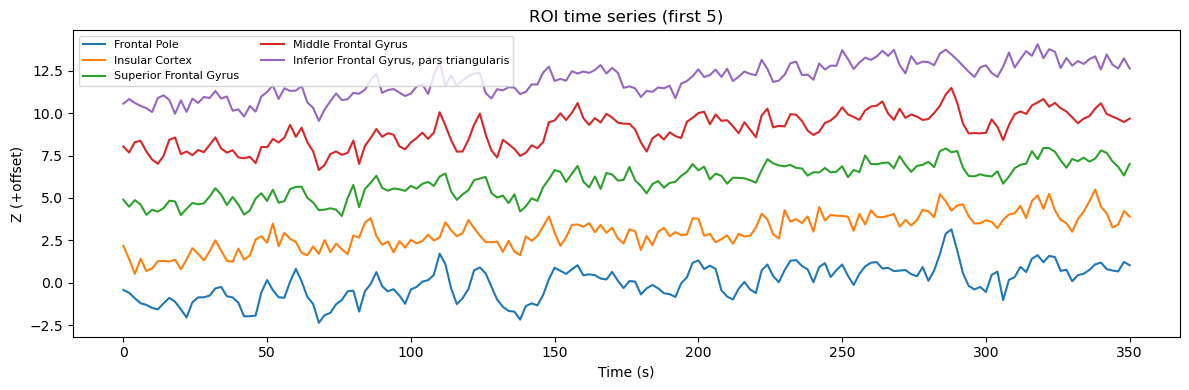

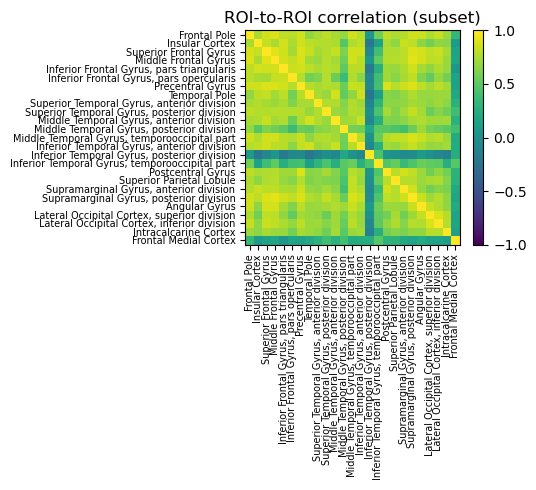

C:\Users\Saye\AppData\Local\Temp\ipykernel_7052\2105966260.py:45: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_func = image.mean_img(func_img)


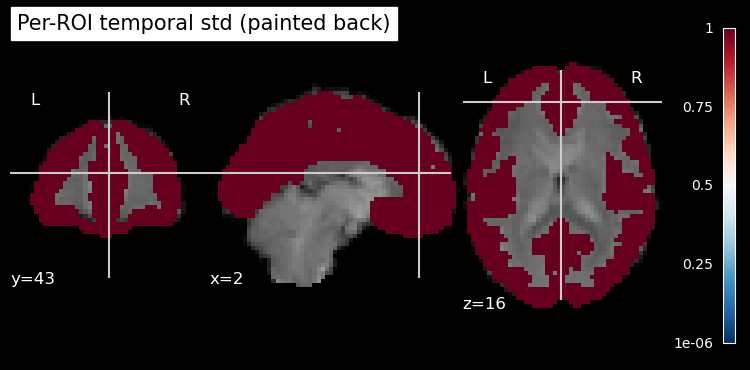

In [ ]:
# --- Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from nilearn import datasets, image, plotting
from nilearn.maskers import NiftiLabelsMasker

# 1) Data & atlas
adhd = datasets.fetch_adhd(n_subjects=1)
FUNC = adhd.func[0]
func_img = image.load_img(FUNC)
TR = func_img.header.get_zooms()[3]

HO = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_img = image.load_img(HO.filename)
region_names = list(HO.labels)   # index aligns with label IDs

# 2) Labels masker → (time, n_rois)
labels_masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True, t_r=TR, labels=region_names)
TS_rois = labels_masker.fit_transform(FUNC)   # (T, n_rois)
names = list(labels_masker.region_names_.values())
print("ROI matrix shape:", TS_rois.shape)

# 3) Plot first 5 ROI time series with offsets
k = 5
t = np.arange(TS_rois.shape[0]) * TR
sep = 3.0
plt.figure(figsize=(12,4))
for j in range(k):
    plt.plot(t, TS_rois[:, j] + j*sep, label=names[j])
plt.xlabel("Time (s)"); plt.ylabel("Z (+offset)")
plt.title("ROI time series (first 5)"); plt.legend(fontsize=8, ncol=2)
plt.tight_layout(); plt.show()

# 4) ROI-to-ROI correlation heatmap (first 25)
corr = np.corrcoef(TS_rois.T)
n = 25
plt.figure(figsize=(6,5))
im = plt.imshow(corr[:n,:n], vmin=-1, vmax=1, interpolation="nearest")
plt.title("ROI-to-ROI correlation (subset)"); plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n), names[:n], rotation=90, fontsize=7); plt.yticks(range(n), names[:n], fontsize=7)
plt.tight_layout(); plt.show()

# 5) Per-ROI temporal std → back to image
roi_std = TS_rois.std(axis=0, ddof=1)  # length n_rois
std_img = labels_masker.inverse_transform(roi_std)
mean_func = image.mean_img(func_img)
plotting.plot_stat_map(std_img, bg_img=mean_func, title="Per-ROI temporal std (painted back)")
plotting.show()


# Task 4 — Capstone (Hard): Seed-based connectivity (spherical seeds)

**Goal.** Define MNI **spherical seeds** (e.g., rIFG & pre-SMA), extract seed signals with **`NiftiSpheresMasker`**, and compute **whole-brain seed-based correlation (SBC)** maps (Z-transformed), including a lightly thresholded display.

**Data set**: `datasets.fetch_adhd(n_subjects=1)`

**Steps for students**

1. Choose seeds (MNI mm) and radius (e.g., 6 mm): `[(48,14,8), (0,24,48)]`.
2. Extract their time series with **`NiftiSpheresMasker(standardize=True)`**.
3. Build a whole-brain **`NiftiMasker(mask_strategy="epi")`**, get voxel time series.
4. Compute **voxelwise r** with each seed → **Fisher Z** maps → plot and threshold (e.g., |Z|>0.3).

[fetch_adhd] Dataset found in C:\Users\Saye\nilearn_data\adhd


C:\Users\Saye\AppData\Local\Temp\ipykernel_7052\441132598.py:11: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_func = image.mean_img(func_img)


Seed TS shape: (176, 2)


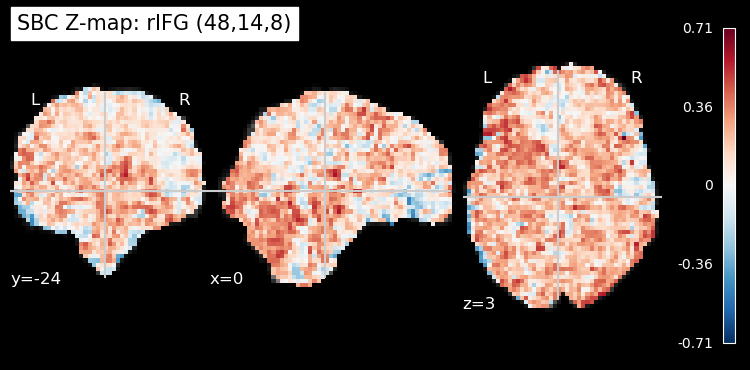

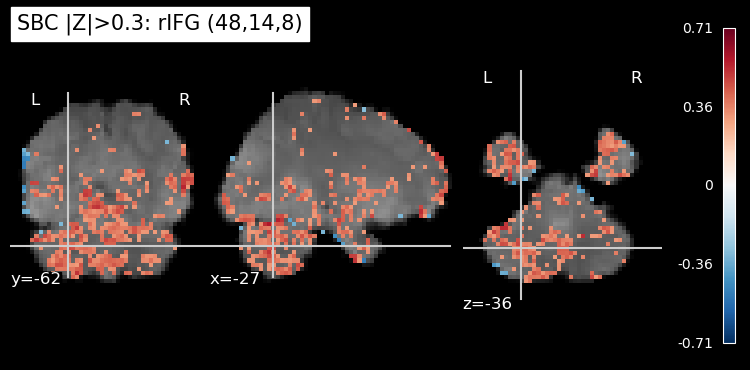

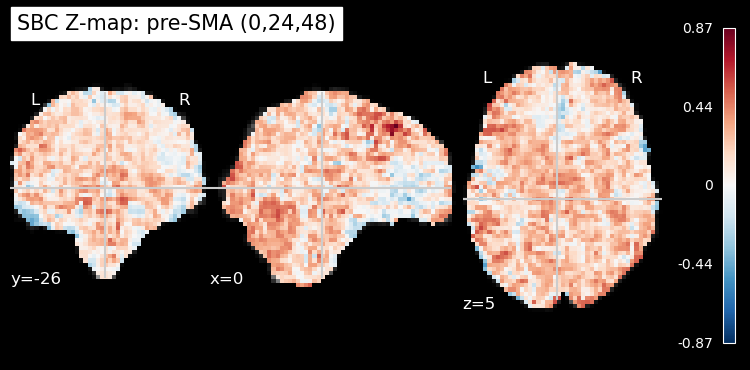

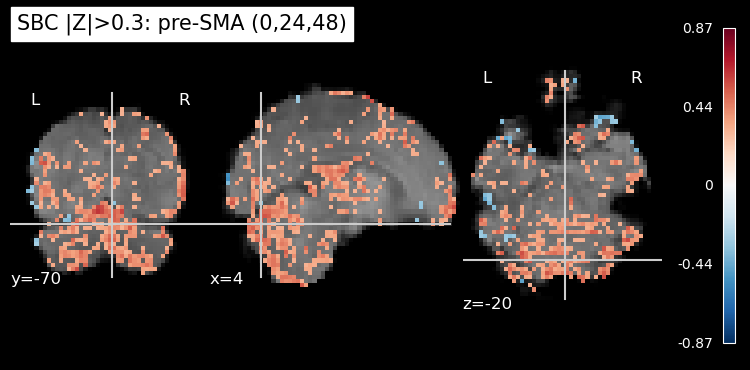

In [4]:
# --- Imports
import numpy as np, matplotlib.pyplot as plt
from nilearn import datasets, image, plotting
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker

# 1) Load fMRI
adhd = datasets.fetch_adhd(n_subjects=1)
FUNC = adhd.func[0]
func_img = image.load_img(FUNC)
TR = func_img.header.get_zooms()[3]
mean_func = image.mean_img(func_img)

# 2) Define seeds (rIFG & pre-SMA) and extract seed time series
seeds = [(48, 14, 8), (0, 24, 48)]     # rIFG, pre-SMA
seed_names = ["rIFG (48,14,8)", "pre-SMA (0,24,48)"]
spheres = NiftiSpheresMasker(seeds=seeds, radius=6, standardize=True, t_r=TR)
TS_seeds = spheres.fit_transform(FUNC)             # (time, n_seeds)
print("Seed TS shape:", TS_seeds.shape)

# 3) Whole-brain masker (auto brain mask from EPI)
wb = NiftiMasker(standardize=True, t_r=TR, mask_strategy="epi")
X = wb.fit_transform(FUNC)                          # (time, n_voxels)

# 4) SBC map for each seed
for s_idx, s_name in enumerate(seed_names):
    seed = TS_seeds[:, s_idx]
    seed_c = seed - seed.mean()
    Xc = X - X.mean(axis=0)                         # demean
    num = Xc.T @ seed_c
    den = (len(seed_c) - 1) * (seed_c.std(ddof=1) * X.std(axis=0, ddof=1) + 1e-8)
    r = (num / den).astype(np.float32)
    r_img = wb.inverse_transform(r)

    # Fisher Z (atanh), clip to avoid inf
    z_img = image.math_img("np.arctanh(np.clip(img, -0.999999, 0.999999))", img=r_img)

    # Plots (raw and lightly thresholded)
    plotting.plot_stat_map(z_img, bg_img=mean_func, title=f"SBC Z-map: {s_name}")
    plotting.show()

    thr = 0.3
    z_thr = image.math_img(f"img * (np.abs(img) > {thr})", img=z_img)
    plotting.plot_stat_map(z_thr, bg_img=mean_func, title=f"SBC |Z|>{thr}: {s_name}")
    plotting.show()
